<img src="bestbuy_logo.png" alt="logo" style="width: 180px;" align="left"/>


# BestBuy API.</br> Базовый анализ продукции и оценки покупателями.

In [1]:
# библиотеки для загрузки данных с API 
import requests
import time
import os

# библиотеки для анализа
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

### Выгрузка данных.

Для начала поймем сколько данных мы имеем:

In [107]:
def show_total_pages_n_columns(url):
    
    '''
    Показывает максимальное количество страниц по 100 товаров 
    и количество самих товаров на Best Buy на данный момент.
    Показывает все колонки и их количество. 
    Описание некоторой части колонок можно прочесть на
    bestbuyapis.github.io/api-documentation/#detail
    
    Параметр:
    url - https://api.bestbuy.com/v1/products?format=json&pageSize=100&apiKey=qhqws47nyvgze2mq3qx4jadt
    '''
    
    req = requests.get(url)
    result = req.json()
    
    # генерация списка колонок
    columns_list = []
    for i in result['products'][1].keys():
        columns_list.append(i)
    
    return print(' Количество страниц по 100 товаров на bestbuy.com на данный момент:\n', 
                 result['totalPages'],'\n','Количество товаров:\n', result['total'],
                 '\n', 'Колоноки в дампе:\n', columns_list, '\n', 'Количество колонок:\n', len(columns_list))

show_total_pages_n_columns('https://api.bestbuy.com/v1/products?format=json&pageSize=100&apiKey=qhqws47nyvgze2mq3qx4jadt')

 Количество страниц по 100 товаров на bestbuy.com на данный момент:
 1931 
 Количество товаров:
 193017 
 Колоноки в дампе:
 ['sku', 'score', 'productId', 'name', 'source', 'type', 'startDate', 'new', 'active', 'lowPriceGuarantee', 'activeUpdateDate', 'regularPrice', 'salePrice', 'clearance', 'onSale', 'planPrice', 'priceWithPlan', 'contracts', 'priceRestriction', 'priceUpdateDate', 'digital', 'preowned', 'carriers', 'planFeatures', 'devices', 'carrierPlans', 'technologyCode', 'carrierModelNumber', 'earlyTerminationFees', 'monthlyRecurringCharge', 'monthlyRecurringChargeGrandTotal', 'activationCharge', 'minutePrice', 'planCategory', 'planType', 'familyIndividualCode', 'validFrom', 'validUntil', 'carrierPlan', 'outletCenter', 'secondaryMarket', 'frequentlyPurchasedWith', 'accessories', 'relatedProducts', 'requiredParts', 'techSupportPlans', 'crossSell', 'salesRankShortTerm', 'salesRankMediumTerm', 'salesRankLongTerm', 'bestSellingRank', 'url', 'spin360Url', 'mobileUrl', 'affiliateUrl', 

#### Описание данных выбранных для выгрузки и последующего анализа:<br/>
**sku** - уникальный номер товара на bestbuy<br/>
**name** - название товара<br/>
**format** - формат носителя мультимедиа<br/>
**manufacturer** - производитель<br/>
**releaseDate** - дата релиза мультимедиа<br/>
**condition** - состояние: новый, после ремонта или б/у<br/>
**salePrice** - цена<br/>
**customerReviewAverage** - средняя оценка покупателем<br/>
**customerReviewCount** - количество оценок у товара<br/>
<br/>


Так как Best Buy API имеет ограничение на выдачу за один запрос на одной странице - 100 товаров, 
(по умолчанию выдает 10, изменяется в url параметре pageSize), напишем цикл который соберет df из множественных запросов.

**Внимание! В зависимости от количества запрашиваемых страниц - скрипт может выполняться очень долго!**

In [115]:
%%time
# замерим время выполнения скрипта. Ожидаемое время выполнения для 190.000 записей ~ 3 часа.

def data_downloader(pages):
    '''
    Загружает данные о продуктах с bestbuy
    
    Параметр pages - задает количество скачиваемых страниц по 100 товаров
    '''

    headers = requests.utils.default_headers()
    headers.update({'User-Agent': 'My User Agent 1.0'})
    # зададим заголовки что бы соединение не сбрасывалось
  
    df = pd.DataFrame()

    for page in range(1, pages): 
    # 1931 максимальное число страниц на best buy на момент создания этого проекта, 
    # текущее количество можно увидеть вызвав функцию show_total_pages_n_columns() 
    # вызываю 1900 страниц по 100 товаров = 190.000 записей

        page = page
        url = f'https://api.bestbuy.com/v1/products?format=json&show=sku,name,format,manufacturer,releaseDate,condition,salePrice,customerReviewAverage,customerReviewCount&pageSize=100&page={page}&apiKey=qhqws47nyvgze2mq3qx4jadt'
        # после параметра show указываем все необходимые нам атрибуты товара 
        # что бы не выгружать все атрибуты, большая часть из которых NaN и 
        # не нужна для анализа.
        # format=json выгружает json, по умолчанию xml
        
        try:
            time.sleep(5)
            # установим время сна, Best Buy сбрасывает соединение при постоянных, быстрых запросах
            # время сна установлено эмпирическим путем на одном компьютере
            r = requests.get(url, headers=headers)
            res = r.json() # json dump
            temp = pd.DataFrame.from_dict(res['products'])
            # создаем запрос и складываем в временные df каждую его итерацию
        except KeyError:
            continue # при большых выборках в json dump попадает некорректное имя ключа, продолжаем программу
        except JSONDecodeError: # тоже ломается дамп
            continue
        except SSLError: # если bestbuy сбросит подключение
            continue

        df = pd.concat([df, temp])
        # объединяем в пустом df все временные
        
    return df

df_bestbuy = data_downloader(1901)            

Wall time: 3h 23min 29s


In [119]:
df.head()

,sku,name,format,manufacturer,releaseDate,condition,salePrice,customerReviewAverage,customerReviewCount
0,1000006,Spy Kids: All the Time in the World [Includes ...,Blu-ray,None,2011-11-22,New,12.99,4.5,77.0
1,1000592,The Mentalist: The Complete Fifth Season [5 Di...,DVD,None,2013-09-17,New,24.99,4.7,58.0
2,1001149,Rambo [Extended Cut] [Blu-ray] [2008],Blu-ray,None,2010-07-27,New,9.99,4.6,532.0
3,1001176,Johnny Handsome [Blu-ray] [1989],Blu-ray,None,2010-07-27,New,9.99,NaN,NaN
4,1003287,Korg - nanoKey2 25-Key USB MIDI Controller - W...,None,Korg,None,New,59.99,4.0,3.0


In [120]:
df.shape

(188900, 9)

Во время выгрузки было утеряно 1100 записей (11 страниц), скорее всего была проблема в json дампе.<br/>
Так же на самом bestbuy, после моих эмпирических наблюдний, количество страниц может прыгать за день +- 300.<br/>
Данных для анализа достаточно.

Сохраним данные в csv файл для надежности

In [117]:
df.to_csv('bestbuy_products.csv', index=False)

In [2]:
df_bestbuy = pd.read_csv('bestbuy_products.csv')

### Разведывательный анализ.

In [73]:
def exploratory_analisys(df):
    '''
    Функция для базового анализа датасета продуктов с bestbuy
    '''
 
    return print('Размер данных:', df.shape, '\n', 'Типы данных:', df.dtypes, '\n',
                 'Cтолбцы:', df.columns, '\n', 
                 '\n', 'Количество значений', df.count(), '\n',
                 'Количество уникальных значений:', df.nunique(), '\n',
                 'Пустые значения:', df.isna().sum(), '\n',
                 'Описательные статистики для числовых данных:', 
                 df.describe(exclude=[object]), '\n'
                 'Форматы мультимедиа:', df.format.unique(), sep='\n')

exploratory_analisys(df_bestbuy)

Размер данных:
(188900, 9)


Типы данных:
sku                        int64
name                      object
format                    object
manufacturer              object
releaseDate               object
condition                 object
salePrice                float64
customerReviewAverage    float64
customerReviewCount      float64
dtype: object


Cтолбцы:
Index(['sku', 'name', 'format', 'manufacturer', 'releaseDate', 'condition',
       'salePrice', 'customerReviewAverage', 'customerReviewCount'],
      dtype='object')




Количество значений
sku                      188900
name                     188900
format                   125342
manufacturer              67250
releaseDate              130960
condition                188900
salePrice                188900
customerReviewAverage     73551
customerReviewCount       73551
dtype: int64


Количество уникальных значений:
sku                      188900
name                     170646
format                       34
manufacturer  

**Выводы по разведывательному анализу:**
<br/>
Данные выгруженны корректно (не учитывая небольшие потери), есть много пустых значений в разных колонках, будем учитывать это при анализе.
<br/>
Максимальная цена товара = 59999.99 долларов. Так же имеются бесплатные товары.<br/> Средняя цена товаров 402 доллара, при этом 50% цен распределены до 29 долларов и 50% после.<br/>
Средняя оценка товаров покупателем 4.4, при этом оцененны 73.551 товара.

In [74]:
df_bestbuy['releaseDate'] = pd.to_datetime(df_bestbuy.releaseDate) # переведем дату в формат даты

### Анализ продукции и оценок.

Всего оценок у товаров

In [12]:
df_bestbuy.customerReviewCount.sum()

27081774.0

Сколько покупательских оценок конкретно в этих данных

In [13]:
df_bestbuy.customerReviewAverage.count()

73551

Посмотрим на товары получившие максимальную оценку минимум от 100 покупателей

In [9]:
df_max_review = df_bestbuy\
    .query('customerReviewAverage == 5.0 and customerReviewCount >= 100')\
    .groupby(['name', 'customerReviewAverage', 'customerReviewCount'], as_index=False)\
    .agg({'name': 'unique'})

df_max_review

,customerReviewAverage,customerReviewCount,name
0,5.0,106.0,[Canon - RF 70-200mm f/2.8L IS USM Telephoto Z...
1,5.0,168.0,[Doctor Who: The Complete David Tennant [Blu-r...
2,5.0,132.0,[Experience Hendrix: The Best of Jimi Hendrix ...
3,5.0,167.0,[Gap - Options $100 Gift Card (Digital Deliver...
4,5.0,167.0,[Gap - Options $25 Gift Card (Digital Delivery...
5,5.0,167.0,[Gap - Options $50 Gift Card (Digital Delivery...
6,5.0,292.0,[Red Robin - 25$ gift card]
7,5.0,176.0,[Samsung - 870 EVO 2TB Internal SSD SATA]
8,5.0,101.0,[Sony - Alpha 7S III Full-frame Mirrorless Cam...
9,5.0,309.0,[Sony - PlayStation 5 - DualSense Wireless Con...


12 уникальных товаров с максимальной оценкой от 100 покупателей.<br/>

Теперь сделаем тоже самое для товаров с минимальной оценкой

In [16]:
df_min_review = df_bestbuy\
    .query('customerReviewAverage == 1.0 and customerReviewCount >= 8')\
    .groupby(['name', 'customerReviewAverage', 'customerReviewCount'], as_index=False)\
    .agg({'name': 'unique'})

df_min_review

,customerReviewAverage,customerReviewCount,name
0,1.0,9.0,[EVGA - Geek Squad Certified Refurbished NVIDI...
1,1.0,10.0,[Harley Quinn: The Complete First Season [4K U...


Таких товаров нет (по 100), макcимальное количество оценок 1 поставленно 10-ю и 9-ю покупателями для двух товаров.<br/> Им очень не понравился мультик про Харли Куин и NVIDIA GeForce RTX 3080 Ti FTW3 ULTRA GAMING 12GB :) <br/>
<br/>
Расшимрим диапазон низких оценок до 2.5, а количество проголосовавших уменьшим до 50

In [11]:
df_min_review_2 = df_bestbuy\
    .query('customerReviewAverage >= 1.0 and customerReviewAverage <= 2.5 and customerReviewCount >= 50')\
    .groupby(['name', 'customerReviewAverage', 'customerReviewCount'], as_index=False)\
    .agg({'name': 'unique'})

df_min_review_2

,customerReviewAverage,customerReviewCount,name
0,1.9,53.0,[Device Diagnostic and Repair]
1,2.5,59.0,[Dynex™ - Case for Samsung Galaxy S10e - Trans...
2,2.5,85.0,[ZAGG - InvisibleShield Fusion Defense Flexibl...


Всего три товара получившие 50 оценок не больше 2.5
<br/>

Посмотрим на 30 товаров за которые проголосовали больше всего покупателей

In [398]:
df_most_reviews_count = df_bestbuy\
    .groupby(['customerReviewCount'], as_index=False)\
    .agg({'name': 'unique'})\
    .sort_values('customerReviewCount', ascending=False).head(30)

df_most_reviews_count

,customerReviewCount,name
2632,63218.0,[Apple - AirPods with Charging Case (2nd gener...
2631,62554.0,[DualShock 4 Wireless Controller for Sony Play...
2630,53068.0,[Nintendo - Switch 32GB Console - Neon Red/Neo...
2629,43010.0,[PopSockets - PopGrip Cell Phone Grip and Stan...
2628,42794.0,[Amazon - Echo Dot (3rd Gen) - Smart Speaker w...
2627,41226.0,[Rocketfish™ - 24' 4K UltraHD/HDR In-Wall Rate...
2626,36890.0,[Logitech - M325 Wireless Optical Ambidextrous...
2625,33077.0,"[Sony - PlayStation Store $100 Gift Card, Sony..."
2624,30339.0,"[Mario Kart 8 Deluxe - Nintendo Switch, Mario ..."
2623,29755.0,[365 Personal (1 Person) (12-Month Subscriptio...


Больше всего покупатели голосуют за технику Apple, игры, консоли и комплектующие к ним. Так же в эту выборку попал личный бренд bestbuy - телевизоры Insignia.

Посмотрим на распределение всех оценок

In [8]:
# зададим стиль и размер для всех графиков
sns.set(rc={'figure.figsize':(15,8)}, style="whitegrid") 

In [3]:
df_review_dist = df_bestbuy\
    .groupby(['customerReviewAverage'], as_index=False)\
    .agg({'sku': 'count'})\
    .rename(columns={'sku': 'review_count'})

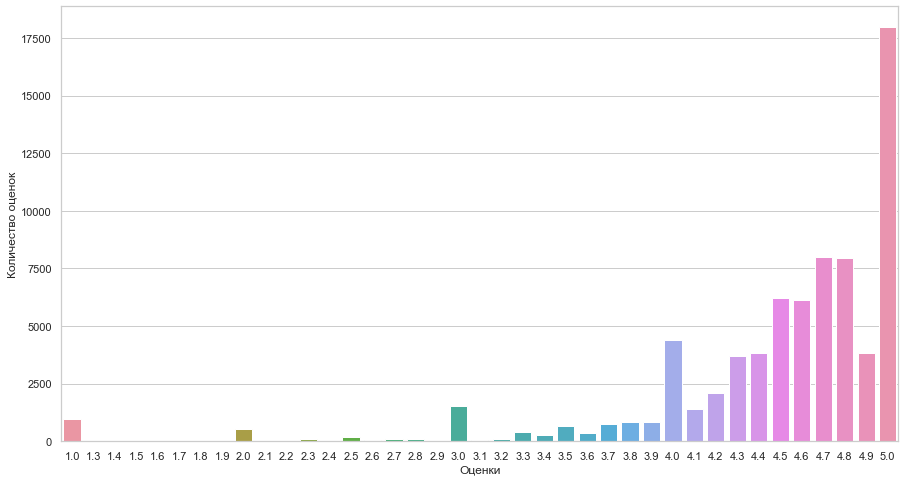

In [9]:
ax = sns.barplot(data = df_review_dist, x = 'customerReviewAverage', y = 'review_count')
ax.set(xlabel='Оценки', ylabel='Количество оценок')
plt.show()

Видим преобладание в основном высоких оценок для товаров на которые есть оценка

<br/>
Всего товаров на сумму

In [11]:
round(df_bestbuy.salePrice.sum(), 2)

76089024.41

<br/>
Топ-10 самых дорогих товаров

In [379]:
df_expensive_top_10 = df_bestbuy\
    .groupby(['salePrice'], as_index=False)\
    .agg({'name': 'unique'})\
    .sort_values('salePrice', ascending=False)\
    .head(10)

df_expensive_top_10

,salePrice,name
3698,59999.99,"[MartinLogan - Neolith 15"" Passive 3-Way Floor..."
3697,31409.00,[Viking - Tuscany 7.6 Cu. Ft. Freestanding Dou...
3696,29999.99,[Sony - VW1025ES 4K Laser Home Theater Project...
3695,29959.00,[Viking - Tuscany 7.6 Cu. Ft. Freestanding Dou...
3694,27999.99,[Sony - VPLXW7000ES 4K HDR Laser Home Theater ...
3693,26759.00,[Viking - Self-Cleaning Freestanding Double Ov...
3692,25999.95,[JVC - 8K via Upscaling 3000lm Laser D-ILA Pr...
3691,25229.00,[Viking - Self-Cleaning Freestanding Double Ov...
3690,25000.00,[Mark Levinson - No534 500W 2-Ch. Class AB Dua...
3689,24999.99,[Mark Levinson - No526 Dual-Monaural Preamplif...


Аудио-колонки за почти 4 миллиона рублей тут самый дорогой товар!)
<br/>
<br/>

Посмотрим что у нас есть из бесплатного и самого дешевого

In [382]:
df_cheap_top_10 = df_bestbuy\
    .query('salePrice != 0.0')\
    .groupby(['salePrice'], as_index=False)\
    .agg({'name': 'unique'})\
    .sort_values('salePrice')\
    .head(10)

df_cheap_top_10

,salePrice,name
0,0.01,"[Bootleg Versions [EP], En Plein Vol, Free Hom..."
1,0.49,"[Monthly Best Buy Protection (up to 24 mo.), B..."
2,0.63,[Monthly AppleCare+ (up to 24 mo.)]
3,0.77,[1-Year Video Games Software ADH GSBTP]
4,0.81,[Monthly AppleCare+ (up to 24 mo.)]
5,0.99,"[FIFA 18 Ultimate Team 100 Points [Digital], F..."
6,1.00,"[INSTALLATION - ELECTRONICS RECYCLING, TIDAL -..."
7,1.21,"[AppleCare (up to 24 mo.), Monthly AppleCare+ ..."
8,1.49,[Dynex™ - Case for Samsung Galaxy S10e - Trans...
9,1.63,[AppleCare+ (up to 24 mo.)]


Товар за 1 цент это странно, но он есть

<br/>

In [384]:
df_free_top_10 = df_bestbuy\
    .query('salePrice < 0.01')\
    .groupby(['salePrice'], as_index=False)\
    .agg({'name': 'unique'})\
    .sort_values('salePrice')\
    .head(10)

df_free_top_10

,salePrice,name
0,0.0,[Super Kirby Clash Standard Edition - Nintendo...


Проверил сайт, bestbuy действительно бесплатно выдает товары. В данном случае это digital версия видео игры, ее можно загрузить прямо с сайта

<br/>
Распределение по состоянию товаров

In [260]:
df_bestbuy.condition.unique()

array(['New', 'Refurbished'], dtype=object)

In [274]:
df_condition = df_bestbuy\
    .groupby('condition', as_index=False)\
    .agg({'sku': 'count'})\
    .rename(columns={'sku':'goods_count'})

df_condition

,condition,goods_count
0,New,188152
1,Refurbished,748


188.152 новых товаров и 748 отремонтированных или б/у

<br/>
Преобладание мультемедиа носителей

In [316]:
df_multimedia = df_bestbuy\
    .groupby('format', as_index=False)\
    .agg({'sku': 'count'})\
    .rename(columns = {'sku': 'count'})\
    .sort_values('count')

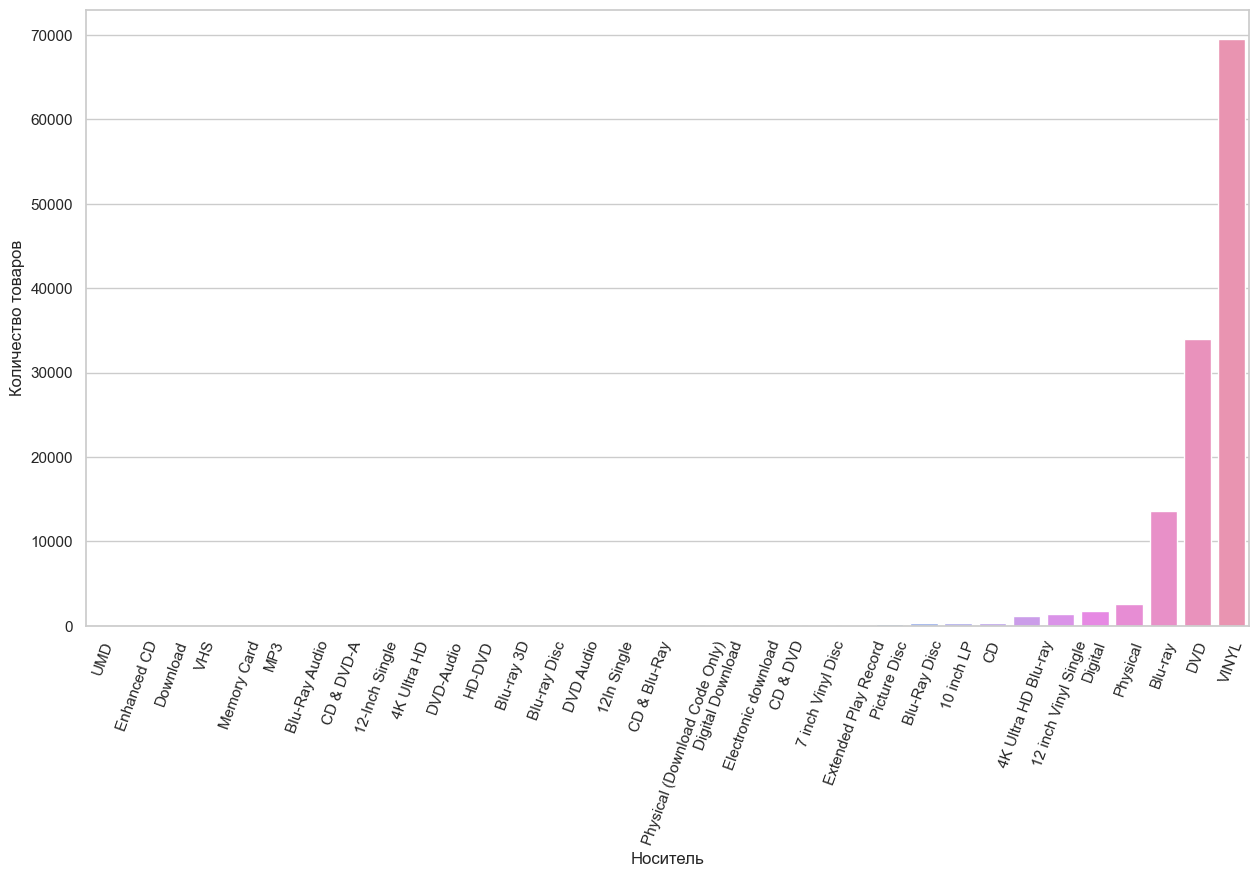

In [315]:
ax = sns.barplot(data = df_multimedia, x = 'format', y = 'count')
plt.xticks(rotation=70)
ax.set(xlabel='Носитель', ylabel='Количество товаров')
plt.show()

Винил живее всех живых :) или никто его не покупает :(

Посмотрим на 10 самых старых виниловых палстинок

In [345]:
df_bestbuy\
    .query('format == "VINYL"')\
    .sort_values('releaseDate')[['name', 'releaseDate']].head(10)

,name,releaseDate
45112,The Five Keys [LP] - VINYL,1977-01-01
45755,Rock 'n' Roll Party [LP] - VINYL,1981-01-01
30374,Like No Other [LP] - VINYL,1983-01-01
51501,Violent Femmes [LP] - VINYL,1983-01-01
45756,Soul of Detroit [LP] - VINYL,1984-01-01
45753,Down Yonder [LP] - VINYL,1984-01-01
81465,100 Weight of Collie Weed [LP] - VINYL,1984-01-01
16167,Marrying for Money [LP] - VINYL,1988-02-11
4743,"Focus on Fusion, Vol. 2 [LP] - VINYL",1988-04-21
3998,One Track Mind [LP] - VINYL,1988-08-01


<br/>
И напоследок, лично для себя, что у них есть из товаров связанных с лучшей в мире спортивной лигой :)

In [40]:
df_nfl = df_bestbuy.set_index(['manufacturer', 'name'])

In [41]:
df_nfl = df_nfl.filter(like='NFL', axis=0)

In [42]:
df_nfl.shape

(114, 7)

In [43]:
df_nfl = df_nfl.reset_index(level=['manufacturer', 'name'])

In [46]:
df_nfl.name.unique()

array(['NFL: History of the Miami Dolphins [2 Discs] [DVD] [2010]',
       'NFL: Super Bowl XLV [Blu-ray] [2011]',
       "NFL: America's Game - 1966 Green Bay Packers - Super Bowl I [DVD]",
       "NFL: America's Game - 1967 Green Bay Packers - Super Bowl II [DVD]",
       "NFL: America's Game - 1968 New York Jets - Super Bowl III [DVD]",
       "NFL: America's Game - 1969 Kansas City Chiefs - Super Bowl IV [DVD]",
       "NFL: America's Game - 1975 Pittsburgh Steelers - Super Bowl X [DVD]",
       "NFL: America's Game - 1983 Los Angeles Raiders - Super Bowl XVIII [DVD]",
       "NFL: America's Game - 1985 Chicago Bears - Super Bowl XX [DVD]",
       "NFL: America's Game - 1992 Dallas Cowboys - Super Bowl XXVII [DVD]",
       "NFL: America's Game - 1994 San Francisco 49ers - Super Bowl XXIX [DVD]",
       "NFL: America's Game - 1997 Denver Broncos - Super Bowl XXXII [DVD]",
       "NFL: America's Game - 1999 St. Louis Rams - Super Bowl XXXIV [DVD]",
       'NFL: Super Bowl LII Champio

В основном игры, записи Супербоулов и несколько разных по номиналу подарочных карт. Странно было бы ожидать что то еще вроде мячей или формы в магазине бытовой и компьтерной техники.

### Общий вывод

У BestBuy довольно широкий выбор продукции: бытовая техника, компьютерная техника, всевозможные мультимедиа и видеоигры и т.п.<br/> Хорошая оценка этой продукции среди покупателей, об этом говорит значительное преобладание высоких оценок из числа проголосовавших. <br/>Цены имеют довольно широкий диапазон от бесплатной продукции до продукции за несколько десятков тысяч долларов.